# Pregunta 4

#### Se tiene una partícula de masa m = 1 en una caja circular. Los radios de a y b son tales que b = 2a.

#### a) Realice una simulación en donde la partícula realiza varios rebotes en las paredes de la caja.  Suponga condiciones iniciales arbitrarias que le permitan hacer lo anterior.

In [11]:
from pylab import*
from numpy import*
%matplotlib inline

In [12]:
def rk4(ec,p_ini,x,args=0,h=0.01):
    #el parámetro args está evaluándose en la segunda coordenada de la ecuación diferencial
    #éste escalar será la fricción que estamos añadiendo a la función.
    
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10.
    #codigo adicional para hacer que cuando se acerque al punto 
    #de rebote los pasos sean más pequeños y nunca sobrepase la barrera.
    
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    
    if args==0:
        for i in xrange(len(tiempos)-1): 
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h) 
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h) 
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h) 
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
            
    else:
        for i in xrange(len(tiempos)-1): 
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args) 
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args) 
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args) 
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
            
    return tiempos,sol

Las ecuaciones que describen a la partícula rebotando son las mismas que en el problema 3, entonces, las vamos a usar nuevamente:

In [13]:
#x[0]=posición_x, x[1]=posición_y, x[2]=vel_x, x[3]=vel_y

def ec_mov(x,t,g=9.8,m=1):
    dx= x[2]
    dy= x[3]
    ddy= 0
    ddx= 0
    return array([dx,dy,ddx,ddy])

Notemos que cuando una pelota rebota lo que ocurre es que la dirección de su velocidad se refleja con respecto a la normal de la superficie. En una caja circular, tendremos que:

$$
\text{Si } \ \ \ \vert \ \vec{r} \vert > b \ \ \ \ \ \ o \ \ \ \ \ \ \vert \ \vec{r} \vert < a \ \ \ \ \ \ \ \ \ \ \ \Rightarrow \ \ \ \ \ \ \ \ \ \ \ v \ \hat{\rho} + r \ \theta \ \hat{\theta}= -v \ \hat{\rho} + r \ \theta \ \hat{\theta}
$$

Sin embargo, trabajar en coordenadas polares es complicado, entonces vamos a usar coordenadas cartesianas.

Notemos que como la tangente de un circulo es perpendicular al radio, entonces, en cualquier punto de la circunferencia, el ángulo entre el centro O y el punto de tangencia B ($w$ en la figura de abajo) es igual al ángulo MBC, entonces el ángulo de inclinación de la tangente es:

$$
\alpha = 180 - 90 - w = 90 - w = 90 - \arctan(\frac{y}{x})
$$

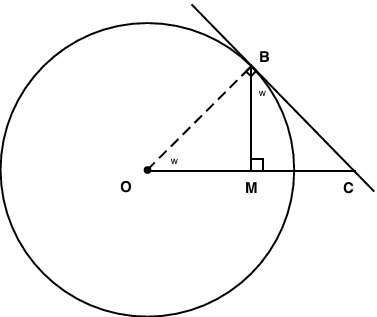

In [21]:
from IPython.display import Image
Image(filename='tangente1.jpg') 

Por lo tanto podemos tratar el rebote como en un simple plano inclinado con ángulo $\alpha$ o $-\alpha$, dependiendo de como sean sus coordenadas:

Cuando $xy>0$:
$$
\text{Si} \ \ \ \vert \ \vec{r} \vert > b \ \ \ \ \ \ o \ \ \ \ \ \ \vert \ \vec{r} \vert < a \ \ \ \ \ \ \ \ \ \Rightarrow \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \vec{v}= (v_x\cos(\alpha)-v_y\sin(\alpha),v_x\sin(\alpha)+v_y\cos(\alpha))
$$

Cuando $xy<0$:
$$
\text{Si} \ \ \ \vert \ \vec{r} \vert > b \ \ \ \ \ \ o \ \ \ \ \ \ \vert \ \vec{r} \vert < a \ \ \ \ \ \ \ \ \ \ \ \Rightarrow \ \ \ \ \ \ \ \ \ \vec{v}= (v_x\cos(-\alpha)-v_y\sin(-\alpha),v_x\sin(-\alpha)+v_y\cos(-\alpha))
$$

Entonces, para describir el rebote con las paredes:

In [76]:
def rebote_techo(ec,pto,b,mi_dt):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec,pto,[0,dt_busqueda])
    y_izq = pto
    y_med = sol[-1,:]
    while abs(b-(y_izq[0]**2+y_izq[1]**2)**(0.5)) > 1e-5:
        if (b-(y_izq[0]**2+y_izq[1]**2)**(0.5))*(b-(y_med[0]**2+y_med[1]**2)**(0.5)) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(ec,reinicio,[0,dt_busqueda])
        y_izq = reinicio   
        y_med = sol[-1,:]
    if (y_izq[0])*(y_izq[1]) > 0.1:
        ang=(90-arctan(y_izq[1]/y_izq[0]))
        y_izq=array([y_izq[0],y_izq[1],y_izq[2]*cos(ang)-y_izq[3]*sin(ang),y_izq[2]*cos(ang)+y_izq[3]*sin(ang)])
    elif (y_izq[0])*(y_izq[1]) < -0.1:
        ang=(90-arctan(y_izq[1]/y_izq[0]))
        y_izq=array([y_izq[0],y_izq[1],y_izq[2]*cos(-ang)-y_izq[3]*sin(-ang),y_izq[2]*cos(-ang)+y_izq[3]*sin(-ang)])
    elif (y_izq[0]) <= 0.1:
        y_izq=array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
    elif (y_izq[1]) <= 0.1:
        y_izq=array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

In [79]:
def rebote_piso(ec,pto,a,mi_dt):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec,pto,[0,dt_busqueda])
    y_izq = pto
    y_med = sol[-1,:]
    while abs(a-(y_izq[0]**2+y_izq[1]**2)**(0.5)) > 1e-5:
        if (a-(y_izq[0]**2+y_izq[1]**2)**(0.5))*(a-(y_med[0]**2+y_med[1]**2)**(0.5)) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(ec,reinicio,[0,dt_busqueda])
        y_izq = reinicio   
        y_med = sol[-1,:]
    if (y_izq[0])*(y_izq[1]) > 0.1:
        ang=(90-arctan(y_izq[1]/y_izq[0]))
        y_izq=array([y_izq[0],y_izq[1],y_izq[2]*cos(ang)-y_izq[3]*sin(ang),y_izq[2]*cos(ang)+y_izq[3]*sin(ang)])
    elif (y_izq[0])*(y_izq[1]) < -0.1:
        ang=(90-arctan(y_izq[1]/y_izq[0]))
        y_izq=array([y_izq[0],y_izq[1],y_izq[2]*cos(-ang)-y_izq[3]*sin(-ang),y_izq[2]*cos(-ang)+y_izq[3]*sin(-ang)])
    elif -0.1 <= (y_izq[1]) <= 0.1:
        y_izq=array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
    elif -0.1 <= (y_izq[0]) <= 0.1:
        y_izq=array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

In [38]:
def trayec(ec,pto_ini,a=1,b=2,mi_dt=0.1,N=10000):
    trayectoria = zeros((N,len(pto_ini)))
    trayectoria[0,:]=array(pto_ini)
    for i in range(N-1):
        t,sol_dt=rk4(ec,trayectoria[i,:],[0,mi_dt])
        radio = (sol_dt[-1,:][0]**2+sol_dt[-1,:][1]**2)**0.5
        if radio > b :
            punto_y = rebote_techo(ec,trayectoria[i,:],b,mi_dt)
            trayectoria[i+1,:] = punto_y
        elif radio < a :
            punto_z = rebote_piso(ec,trayectoria[i,:],a,mi_dt)
            trayectoria[i+1,:] = punto_z
        else:
            trayectoria[i+1,:]=sol_dt[-1,:]
    return trayectoria

/Users/Maria_Erandi/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in double_scalars
/Users/Maria_Erandi/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in add
/Users/Maria_Erandi/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in multiply
/Users/Maria_Erandi/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in double_scalars
/Users/Maria_Erandi/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars


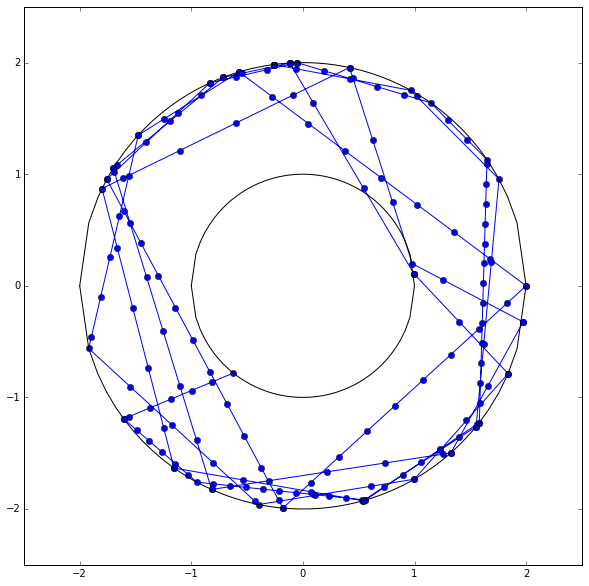

In [72]:
fig=figure(figsize=(10,10))
xlim([-2.5,2.5]),ylim([-2.5,2.5])
a=1 #radio de la circunferencia interior
b=2 #radio de la circunferencia exterior
angulo=9*pi/7

trayectoria1=trayec(ec_mov,[cos(angulo),sin(angulo),3*cos(angulo),sin(angulo)])
plot(trayectoria1[:,0],trayectoria1[:,1],'o-')
x,y,u,v=linspace(-b,b),linspace(-b,b),linspace(-a,a),linspace(-a,a)
plot(x,sqrt(-x**2+b**2),'black')
plot(y,-sqrt(-y**2+b**2),'black')
plot(u,sqrt(-u**2+a**2),'black')
plot(v,-sqrt(-v**2+a**2),'black')
show()

#### (b) Existen condiciones iniciales que hagan que la partícula quede encasillada en sólo un sector dela caja?. De ser así muestre cuáles son tales condiciones o demuestre porque no se pueden obtener dicha situación.

La partícula se puede quedar encasillada en un solo sector si golpea un punto de la caja de tal forma que su ángulo de impacto sea de 90º con respecto a la tangete en el punto de impacto.

En dicha situación la pelota rebotaría entre dos puntos indefinidamente.

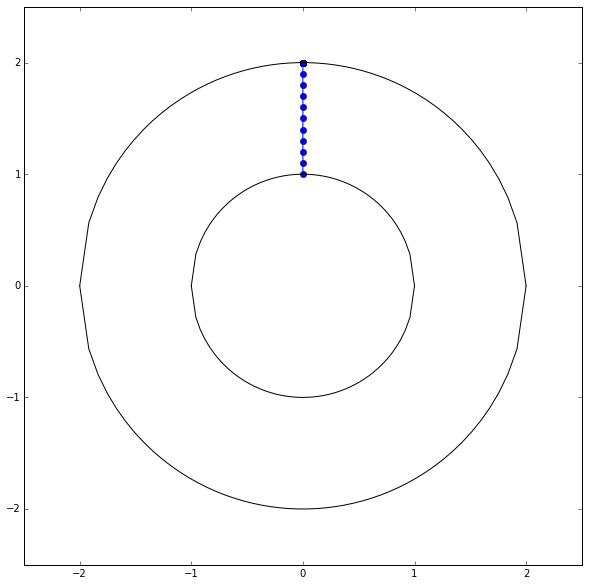

In [82]:
fig=figure(figsize=(10,10))
xlim([-2.5,2.5]),ylim([-2.5,2.5])
a=1 
b=2
z=0
m=1

trayectoria2=trayec(ec_mov,[sin(z),cos(z),m*sin(z),m*cos(z)])
plot(trayectoria2[:,0],trayectoria2[:,1],'o-')
x,y,u,v=linspace(-b,b),linspace(-b,b),linspace(-a,a),linspace(-a,a)
plot(x,sqrt(-x**2+b**2),'black')
plot(y,-sqrt(-y**2+b**2),'black')
plot(u,sqrt(-u**2+a**2),'black')
plot(v,-sqrt(-v**2+a**2),'black')
show()

#### (c) Si ahora se tiene un campo gravitacional uniforme $\vec{g} = 10 \hat{n}$. Que condiciones iniciales se tendrán que cumplir para que la partícula sólo pueda ocupar la mitad de la dona.

En éste caso las ecuaciones de movimiento se cambian a:

In [60]:
#x[0]=posición_x, x[1]=posición_y, x[2]=vel_x, x[3]=vel_y

def ec_mov1(x,t,g=10,m=1):
    dx= x[2]
    dy= x[3]
    ddy= -g/m
    ddx= 0
    return array([dx,dy,ddx,ddy])

Si lanzamos la pelota con poca velocidad y desde algún punto en la mitad con coordenadas $y$ negativas, por la gravedad la pelota no podrá rebotar tanto como para llegar a la parte superior de la dona. Es decir, la partícula quedará encasillada en la parte inferior de la dona.

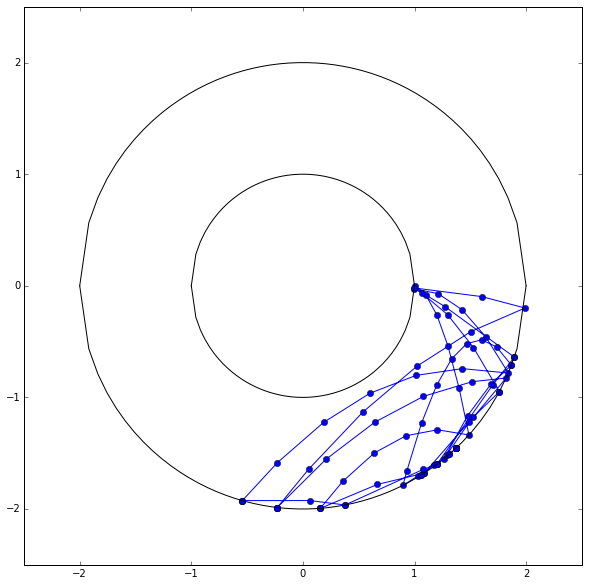

In [78]:
fig=figure(figsize=(10,10))
xlim([-2.5,2.5]),ylim([-2.5,2.5])
a=1 
b=2

trayectoria3=trayec(ec_mov1,[1,0,1,-.3])
plot(trayectoria3[:,0],trayectoria3[:,1],'o-')
x,y,u,v=linspace(-b,b),linspace(-b,b),linspace(-a,a),linspace(-a,a)
plot(x,sqrt(-x**2+b**2),'black')
plot(y,-sqrt(-y**2+b**2),'black')
plot(u,sqrt(-u**2+a**2),'black')
plot(v,-sqrt(-v**2+a**2),'black')
show()